In [1]:
#100*100 matching market
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment

# 示例数据
donors_names = ['d' + str(i) for i in range(1, 101)]
recipients_names = ['r' + str(i) for i in range(1, 101)]

# 创建初始匹配
initial_match = list(zip(donors_names, recipients_names))

# 加载矩阵数据
don_pre= pd.read_csv('C:\\Users\\Hongan Li\\Desktop\\Research Project\\Code\\final_code\\preference matrices\\don_pre_100_2.csv', index_col=0)
reci_pre = pd.read_csv('C:\\Users\\Hongan Li\\Desktop\\Research Project\\Code\\final_code\\preference matrices\\reci_pre_100_2.csv', index_col=0)

In [1]:
#20*20 matching market
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment

# 示例数据
donors_names = ['d' + str(i) for i in range(1, 21)]
recipients_names = ['r' + str(i) for i in range(1, 21)]

# 创建初始匹配
initial_match = list(zip(donors_names, recipients_names))

# 加载矩阵数据
don_pre= pd.read_csv('C:\\Users\\Hongan Li\\Desktop\\Research Project\\Code\\final_code\\preference matrices\\don_pre_20_2.csv', index_col=0)
reci_pre = pd.read_csv('C:\\Users\\Hongan Li\\Desktop\\Research Project\\Code\\final_code\\preference matrices\\reci_pre_20_2.csv', index_col=0)

In [2]:
import random
import numpy as np
import time
import matplotlib.pyplot as plt

def find_all_instabilities(matching, reci_pre, don_pre):
    matching_dict = {donor: recipient for donor, recipient in matching}
    instabilities = {}

    for donor, recipient in matching_dict.items():
        matched_recipient_rank = don_pre.loc[donor, recipient]
        donor_preferences = don_pre.loc[donor]

        # Recipients preferred over the matched recipient
        preferred_recipients = donor_preferences[donor_preferences < matched_recipient_rank].index.tolist()

        for other_recipient in preferred_recipients:
            other_donor_list = [d for d, r in matching if r == other_recipient]
            if other_donor_list:
                other_donor = other_donor_list[0]

                # Check if the other recipient prefers this donor over their current match
                if reci_pre.loc[other_recipient, donor] < reci_pre.loc[other_recipient, other_donor]:
                    instabilities[(donor, other_recipient)] = (
                        don_pre.loc[donor, other_recipient],
                        reci_pre.loc[other_recipient, donor]
                    )

    return instabilities

def find_undominated_blocking_pair(blocking_pairs, reci_pre, don_pre):
    undominated_pair = None
    best_recipient_score = float('inf')
    best_donor_score = float('inf')
    
    for donor, recipient in blocking_pairs:
        recipient_score = reci_pre.loc[recipient, donor]
        donor_score = don_pre.loc[donor, recipient]
        
        # If the current blocking pair is better than the previous undominated pair
        if (recipient_score < best_recipient_score) or (recipient_score == best_recipient_score and donor_score < best_donor_score):
            best_recipient_score = recipient_score
            best_donor_score = donor_score
            undominated_pair = (donor, recipient)
    
    return undominated_pair

def combine_final_matching(initial_matching, undominated_pair, reci_pre, don_pre):
    new_matching = []
    donor, recipient = undominated_pair

    # Find the current matches of the donor and recipient involved in the undominated pair
    matched_recipient = next(r for d, r in initial_matching if d == donor)
    matched_donor = next(d for d, r in initial_matching if r == recipient)
    
    for d, r in initial_matching:
        if d == donor:
            new_matching.append((d, recipient))
        elif d == matched_donor:
            new_matching.append((d, matched_recipient))
        else:
            new_matching.append((d, r))
    
    return new_matching

def calculate_penalty(matching, reci_pre, don_pre):
    instabilities = find_all_instabilities(matching, reci_pre, don_pre)
    return len(instabilities), instabilities

def generate_population(size, initial_matching):
    population = []
    for _ in range(size):
        new_matching = initial_matching.copy()
        # Randomly swap pairs to create diversity in the population
        i, j = random.sample(range(len(new_matching)), 2)
        new_matching[i], new_matching[j] = new_matching[j], new_matching[i]
        population.append(new_matching)
    return population

def neighbor(solution, reci_pre, don_pre):
    # Use the neighborhood search with undominated blocking pairs
    penalty, instabilities = calculate_penalty(solution, reci_pre, don_pre)
    if penalty > 0:
        blocking_pairs = list(instabilities.keys())
        undominated_pair = find_undominated_blocking_pair(blocking_pairs, reci_pre, don_pre)
        new_solution = combine_final_matching(solution, undominated_pair, reci_pre, don_pre)
        return new_solution
    else:
        # If solution is stable, perform a random swap to explore new solutions
        new_solution = solution.copy()
        i, j = random.sample(range(len(new_solution)), 2)
        new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
        return new_solution

def should_accept(candidate_cost, current_cost, temperature):
    if candidate_cost < current_cost:
        return True
    else:
        cost_diff = candidate_cost - current_cost
        prob = np.exp(-cost_diff / temperature)
        return random.random() < prob

def hybrid_abc_sa_stable_matching(initial_matching, reci_pre, don_pre, CS=10, onlookers=200, max_cycles=200, initial_temp=1000, alpha=0.9, stop_temp=0.01):
    population = generate_population(CS, initial_matching)
    costs = []
    for ind in population:
        cost, _ = calculate_penalty(ind, reci_pre, don_pre)
        costs.append(cost)
    best_idx = np.argmin(costs)
    best_solution = population[best_idx]
    best_cost = costs[best_idx]
    temperature = initial_temp

    # Lists to record temperature and penalty over iterations
    penalties_over_time = []
    temperatures_over_time = []

    start_time = time.time()

    for cycle in range(max_cycles):
        # Record current temperature
        temperatures_over_time.append(temperature)

        # Employed Bee Phase
        for i in range(CS):
            candidate = neighbor(population[i], reci_pre, don_pre)
            candidate_cost, _ = calculate_penalty(candidate, reci_pre, don_pre)
            current_cost = costs[i]

            if should_accept(candidate_cost, current_cost, temperature):
                population[i] = candidate
                costs[i] = candidate_cost

        # Onlooker Bee Phase with Monte Carlo process
        fitness = [1 / (1 + cost) for cost in costs]
        total_fitness = sum(fitness)
        probabilities = [fit / total_fitness for fit in fitness]

        i = 0
        t = 0
        while t < onlookers:
            if random.random() < probabilities[i]:
                candidate = neighbor(population[i], reci_pre, don_pre)
                candidate_cost, _ = calculate_penalty(candidate, reci_pre, don_pre)
                current_cost = costs[i]

                if should_accept(candidate_cost, current_cost, temperature):
                    population[i] = candidate
                    costs[i] = candidate_cost
                t += 1
            i = (i + 1) % CS

        # Scout Bee Phase
        for i in range(CS):
            # Implement a condition to replace stagnated solutions
            if temperature < stop_temp:
                # Replace with a new random solution
                population[i] = generate_population(1, initial_matching)[0]
                costs[i], _ = calculate_penalty(population[i], reci_pre, don_pre)

        # Update temperature
        temperature *= alpha

        # Update best solution
        best_idx = np.argmin(costs)
        if costs[best_idx] < best_cost:
            best_solution = population[best_idx]
            best_cost = costs[best_idx]
        

        # Record penalty for plotting
        penalties_over_time.append(best_cost)
        
        # Optional: Stop if stable matching is found
        if best_cost == 0:
            break

    end_time = time.time()
    time_taken = end_time - start_time

    return best_solution, best_cost, penalties_over_time, temperatures_over_time, time_taken

Best Matching: [('d19', 'r15'), ('d2', 'r5'), ('d12', 'r20'), ('d13', 'r6'), ('d1', 'r11'), ('d15', 'r3'), ('d14', 'r18'), ('d10', 'r12'), ('d5', 'r7'), ('d20', 'r14'), ('d6', 'r16'), ('d18', 'r17'), ('d7', 'r4'), ('d8', 'r10'), ('d17', 'r9'), ('d16', 'r2'), ('d9', 'r1'), ('d3', 'r13'), ('d4', 'r8'), ('d11', 'r19')]
Best Penalty: 0
Time Taken: 4.28 seconds


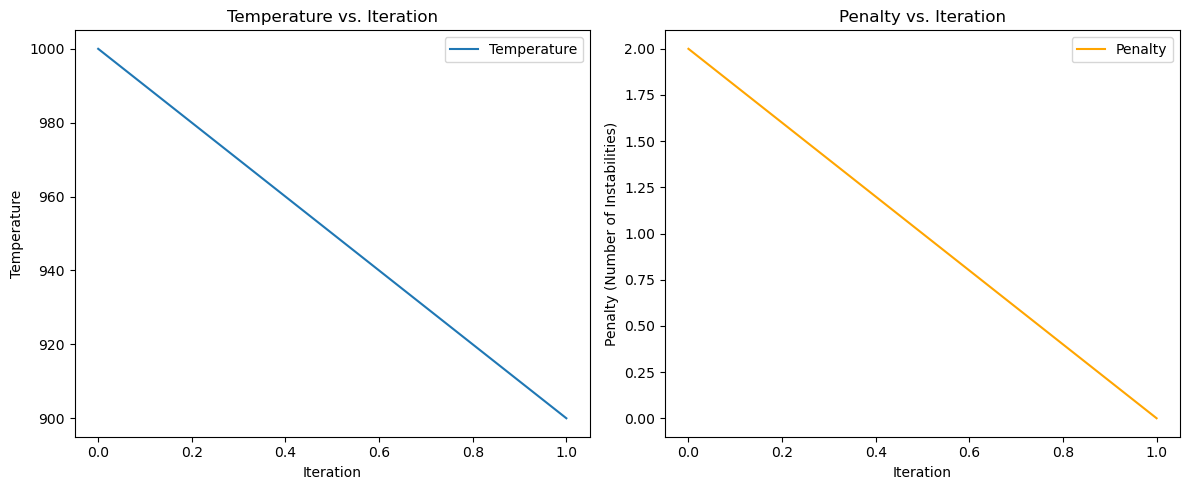

In [3]:
# Parameters
CS = 10              # Colony Size
onlookers = 200      # Number of onlooker bees
max_cycles = 200     # Maximum number of cycles
initial_temp = 1000  # Initial temperature for simulated annealing
alpha = 0.9          # Cooling rate
stop_temp = 0.01     # Stopping temperature

# Run the hybrid ABC-SA algorithm
best_matching, best_penalty, penalties_over_time, temperatures_over_time, time_taken = hybrid_abc_sa_stable_matching(
    initial_match, reci_pre, don_pre, CS, onlookers, max_cycles, initial_temp, alpha, stop_temp)

# Print final results
print("Best Matching:", best_matching)
print("Best Penalty:", best_penalty)
print(f"Time Taken: {time_taken:.2f} seconds")

# Plot the penalty over iterations
iterations = list(range(len(penalties_over_time)))

plt.figure(figsize=(12, 5))

# Plot temperature curve
plt.subplot(1, 2, 1)
plt.plot(iterations, temperatures_over_time, label='Temperature')
plt.xlabel('Iteration')
plt.ylabel('Temperature')
plt.title('Temperature vs. Iteration')
plt.legend()

# Plot penalty curve
plt.subplot(1, 2, 2)
plt.plot(iterations, penalties_over_time, label='Penalty', color='orange')
plt.xlabel('Iteration')
plt.ylabel('Penalty (Number of Instabilities)')
plt.title('Penalty vs. Iteration')
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
instabilty = find_all_instabilities(best_matching, reci_pre, don_pre)

if instabilty:
    print('The blocking pairs are:')
    for i in instabilty:
        print(i)
else:
    print('The matching is stable.')

The matching is stable.
